# Práctica 2: Clasificador de tweets
## por Federico Pardo García

## Máster en BIG DATA: Tecnologías de Gestión de Información No Estructurada 2020/2021


## Introducción

En este trabajo, se nos pide desarrollar un algoritmo de aprendizaje basado en máquinas de soporte vectorial que nos permita clasificar si un tweet pertenece a una persona u otra.
El objetivo principal es comprobar si varias personalidades son más o menos difíciles de clasificar en base a lo parecidas que sean, que sería lo normal.
Por tanto, partímos de la hipótesis de que dos personalidades parecidas serán más difíciles de diferenciar respecto a dos personalidades bien diferenciadas.

### ¿Por qué hacemos comprobaciones dos a dos?

Debido a la naturaleza del algoritmo de aprendizaje a utilizar, solo podemos comparar cada par de personalidades por separado.
Las máquinas de soporte vectorial (SVM) son algoritmos de aprendizaje que separan los datos en dos grupos lo más diferenciados posibles, por lo que este es el factor limitante a la hora de realizar la experimentación.

Podríamos haber utilizado otro algoritmo de aprendizaje, pero las máquinas de soporte vectorial tienen la peculiaridad de que son muy eficientes a la hora de clasificar texto, ya que se suele representar en forma de vectores mediante _bag of words_.

### Importe de librerías

In [1]:
import twitter
import xml.etree.ElementTree as ET
import numpy as np
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import PredefinedSplit
import pandas as pd
import os.path

# Para el opcional
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import timedelta
from statistics import mean

Para garantizar la reproducibilidad de los experimentos, establecemos una semilla para todas las operaciones aleatorias.

In [2]:
SEED_VALUE = 1234

Comenzamos cargando la API de Twitter, que nos permitirá comunicarnos con la misma para obtener los tweets.
Incluimos el parámetro `sleep_on_rate_limit` a `True` para que en caso de llegar al límite de tweets que podemos pedir de una tirada, sea la propia librería la que haga una parada hasta que sea posible volver a obtener los tweets.
Esto es así ya que Twitter limita el número de peticiones que se pueden realizar desde su API, para evitar un uso indebido de la misma o un ataque, y asegurando de esta forma los recursos para todos los usuarios que quieran utilizarla.

In [3]:
api = twitter.Api(consumer_key='vJx3WkjUjATxveo8NK3tsVniM',
                  consumer_secret='DLuw7WXYXwLIAVG2GtQHcVjOWM8Mq5a1qn3ZynniQSbSfKWSvM',
                  access_token_key='769542991832907780-yM58uOw32rNLJe0OD3EBmD5KwdsScwv',
                  access_token_secret='wBAtr8mhrOBQZE1ccv1y3tSAO8om2afmodatnj8gKLswn',
                  sleep_on_rate_limit=True, # Nos permite despreocuparnos de rate_limits
                  tweet_mode='extended')


A continuación, definimos una serie de funciones que nos serán útiles para obtener los tweets de un usuario, así como almacenarlos y extraerlos de un fichero XML, evitando tener que conectarnos a twitter en cada ocasión para obtener la _timeline_ de un usuario.

La función `get_tweets` ha sido obtenida y adaptada de la siguiente [fuente](
https://medium.com/agatha-codes/0-to-280-getting-twitter-timeline-data-for-your-awesome-nlp-project-ff41b941ed6).

In [4]:
def get_tweets(first_200, screen_name, last_id):
    '''
    Get all tweets from a user account
    '''
    all_tweets = []
    all_tweets.extend(first_200)
    for i in range(5000):
        new = api.GetUserTimeline(screen_name=screen_name, max_id = last_id-1)
        if len(new) > 0:
            all_tweets.extend(new)
            last_id = new[-1].id
        else:
            break
    return all_tweets


def dump_XML(tweets, name):
    '''
    Takes a collection of tweets and a name
    and saves the collection in an XML file named as 'name'.
    '''
    items = ET.Element("data")
    for tweet in tweets:
        element = ET.SubElement(items, 'tweet')
        element.set('id', str(tweet.id))
        element.set('user_id', str(tweet.user.id))
        element.set('user_name', tweet.user.screen_name)
        element.set('date', str(tweet.created_at_in_seconds))
        element.text = tweet.full_text + '\n'
            

    mydata = ET.ElementTree(items)
    mydata.write("./extracted_users/" + name + ".xml")


def extract_XML(filename, include_date = False):
    '''
    Retrives de tweets collection from the 
    xml file including the date.
    '''
    tree = ET.ElementTree(file = "./extracted_users/" + filename)
    root = tree.getroot()
    collection = []
    for doc in root:
        text = doc.text
        if include_date:
            date = datetime.fromtimestamp(int(doc.attrib['date']))
            collection.append((text, date))
        else:
            collection.append(text)
    return collection


def timeline(name):
    first200 = api.GetUserTimeline(screen_name=name, count=200)
    all_tweets = get_tweets(first200, name, first200[-1].id)
    dump_XML(all_tweets, name)

### Usuarios seleccionados
Los usuarios seleccionados son:

* _George Russell_: Joven piloto de Formula 1.
* _Lando Norris_: Joven piloto de Formula 1.
* _Bill Gates_: Cofundador de Microsoft y de Bill & Melinda Gates Foundation. Filántropo.

Podría haber seleccionado un cuarto usuario, pero para la experimentación no es necesario, ya que vamos reutilizar uno de ellos en ambos ejercicios.
He escogido a George Russell y a Lando Norris como usuarios "similares", ya que ambos son pilotos jovenes procedentes de Reino Unido y comenzando sus trayectorias en la Formula 1.
Podemos decir que son perfiles similares, a la hora de ser clasificados.

Por otro lado, he decidido esocger al filántropo y magnate Bill Gates, como contrapunto a cualquiera de los otros dos usuarios.
El contenido y probablemnte el lenguaje utilizado será diferente en el caso de Gates respecto a cualquiera de los jovenes pilotos, por lo que es de esperar que sea sencillo distinguirlos.



In [5]:
# Introducimos los nombres de usuario
users = ['GeorgeRussell63','LandoNorris', 'BillGates']
for user in users:
    if not os.path.exists("./extracted_users/" + user + ".xml"):
        timeline(user)

## Clasificación de personalidades similares

### División en 70% train y 30% test

Primero debemos separar los datos de entrenamiento de los de test.
Para la experimentación, se nos pide expresamente que reservemos el __30% más reciente__ para el conjunto de test, por lo que a la hora de seleccionar los mejores hiperparámetros para el algoritmo, trabajaremos con datos que pueden pertenecer a hace unas semanas o meses en función de la frecuencia de las publicaciones de los perfiles seleccionados.

In [6]:
def split_TrainTest(vectorizedDS, corpus1_len, corpus2_len):
    '''
    Dado el vector de un corpus y las longitudes de los corpus que lo componen,
    lo separará en train y test con sus correspondientes etiquetas.
    '''
    
    # Separamos el data frame según el autor del tweet
    corpus1vectorized = vectorizedDS[:corpus1_len]
    corpus2vectorized = vectorizedDS[corpus2_len:]
    
    # Punto de corte para cada autor
    nCorpus1 = int(corpus1_len*0.7)
    nCorpus2 = int(corpus2_len*0.7)
    
    # Predictores de entrenamiento (usamos los más antiguos)
    x1train = corpus1vectorized[-nCorpus1:]
    x2train = corpus2vectorized[-nCorpus2:]
    frames = [x1train,x2train]
    xTrain = pd.concat(frames)

    # Predictores de test (usamos los más modernos)
    x1test = corpus1vectorized[:corpus1_len-nCorpus1]
    x2test = corpus2vectorized[:corpus2_len-nCorpus2]
    frames = [x1test,x2test]
    xTest = pd.concat(frames)
    
    # Salida de entrenamiento
    y1train = (np.zeros((nCorpus1, 1))).tolist()
    y2train = (np.ones((nCorpus2, 1))).tolist()
    y1train.extend(y2train)
    yTrain = y1train
    
    # Salida de test
    y1test = (np.zeros((corpus1_len-nCorpus1, 1))).tolist()
    y2test = (np.ones((corpus2_len-nCorpus2, 1))).tolist()
    y1test.extend(y2test)
    yTest = y1test
    
    return (xTrain, yTrain, xTest, yTest)

def get_bag_of_words(corpus):
    '''
    Devuelve una representación "bag of words" para un corpus de documentos.
    '''
    english_stop_words = text.ENGLISH_STOP_WORDS
    vectorizer = CountVectorizer(stop_words = english_stop_words, min_df=20)
    corpusVectorized = vectorizer.fit_transform(corpus)
    df_tf = pd.DataFrame(corpusVectorized.todense(), columns=vectorizer.get_feature_names())
    return df_tf

In [7]:
# Unificamos los corpus y lo procesamos
russell = extract_XML('GeorgeRussell63.xml')
norris = extract_XML('LandoNorris.xml')
corpus = russell + norris

df_tf = get_bag_of_words(corpus)
(xTrain, yTrain, xTest, yTest) = split_TrainTest(df_tf, len(russell), len(norris))
yTrain = pd.DataFrame(yTrain).values.ravel()
yTest = pd.DataFrame(yTest).values.ravel()

### Entrenamiento con SVC

Comenzamos realizando un GridSearch, que nos perimte probar diversos hiperparámetros para intuir que combinación de los mismos puede funcionar mejor para este tipo de problema.
En el propio enunciado se nos indica que solo podemos jugar con los hiperparámetros `C` y `kernel`, por lo que he decidido probar las siguientes combinaciones:

In [8]:
hyperparameters ={'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
                 'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10],
                 'random_state':[SEED_VALUE]}

Como métrica para puntuar los modelos, he decidido optar por `accuracy`, que se calcula como $\dfrac{a}{\left(samples\right)}$ donde $a$ es el número de aciertos $samples$ el número de muestras que se han clasificado.

In [9]:
clf = SVC()
modelCV = GridSearchCV(clf,
                       hyperparameters,
                       cv=5,
                       scoring='accuracy',
                       n_jobs=-1,
                       return_train_score=True)
np.random.seed(SEED_VALUE)
modelCV.fit(xTrain, yTrain)
cv_results = pd.DataFrame(modelCV.cv_results_)

Para no mostrar la lista completa de hiperparámetros, se incluyen unicamente los 10 primeros.
De esta forma, podremos intentar extrapolar si algún hiperparámetro en particular funciona bien para este problema o si podemos descartar otros tantos.

In [10]:
top10 = cv_results[cv_results['rank_test_score'] <= 10]
display(top10.loc[:, ['param_kernel', 'param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']])

,param_kernel,param_C,mean_test_score,std_test_score,rank_test_score
20,linear,0.5,0.786183,0.090945,5
24,linear,1,0.785936,0.085328,6
26,rbf,1,0.782963,0.089642,10
28,linear,2,0.783954,0.088090,9
30,rbf,2,0.788908,0.091792,3
31,sigmoid,2,0.784211,0.062062,8
34,rbf,3,0.791384,0.091430,2
38,rbf,4,0.785437,0.092005,7
42,rbf,5,0.788656,0.087229,4
46,rbf,10,0.796084,0.087601,1


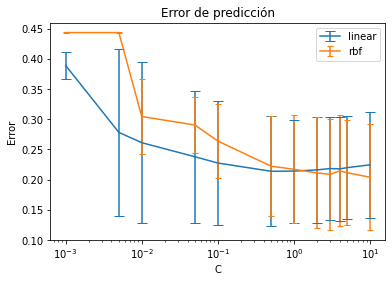

In [11]:
rbf_kernel = cv_results[cv_results['param_kernel'] == 'rbf']
linear_kernel = cv_results[cv_results['param_kernel'] == 'linear']

plt.errorbar(linear_kernel["param_C"],
            1-linear_kernel['mean_test_score'],
            linear_kernel['std_test_score'],
            label = 'linear',
            capsize=5)

plt.errorbar(rbf_kernel["param_C"],
            1-rbf_kernel['mean_test_score'],
            rbf_kernel['std_test_score'],
            label = 'rbf',
            capsize=3)

plt.title("Error de predicción")
plt.xlabel("C")
plt.ylabel("Error")
plt.legend(loc='upper right')
plt.xscale('log')
plt.show()

Con estos resultados podemos intuir varias cosas.
El kernel `rbf` parece ser el que mejores resultados da para el problema en cuestión.
También observamos que a mayor parámetro `C`, se obtiene una precisión similar con una desviación estandar mejor.
Esto nos puede llevar a pensar que estos modelos generalizarán mejor que aquellos con un `C` inferior.
Por ello, __personalmente__ he seleccionado la __mejor combinación de hiperparámetros__ con `kernel = rbf` y `C = 10`.

In [12]:
clf = SVC(kernel = 'rbf', C = 10, random_state = SEED_VALUE)

clf.fit(xTrain, yTrain)
result = clf.predict(xTest)
print("Exactitud del algoritmo ('Accuracy'): {}".format(accuracy_score(yTest, result)))

Exactitud del algoritmo ('Accuracy'): 0.7209705372616985


## Clasificación de personalidades diferentes

Para las personalidades diferentes, seguimos la misma metodología que para las similares, cambiando esta vez las colecciones de tweets.
En este caso, se compararán Bill Gates frente a Lando Norris.

In [13]:
gates = extract_XML('BillGates.xml')
norris = extract_XML('LandoNorris.xml')
corpus = gates + norris

df_tf = get_bag_of_words(corpus)
(xTrain, yTrain, xTest, yTest) = split_TrainTest(df_tf, len(gates), len(norris))
yTrain = pd.DataFrame(yTrain).values.ravel()
yTest = pd.DataFrame(yTest).values.ravel()

Basándonos en la experiencia de las personalidades similares y dado que el problema sigue siendo del mismo tipo, vamos a reducir el número de hiperparámetros a probar.

In [14]:
clf = SVC()
hyperparameters ={'kernel':['rbf',],
                 'C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                 'random_state':[SEED_VALUE]}

modelCV = GridSearchCV(clf,
                       hyperparameters,
                       cv=5,
                       scoring='accuracy',
                       n_jobs=-1,
                       return_train_score=True)
np.random.seed(SEED_VALUE)
modelCV.fit(xTrain, yTrain)
cv_results = pd.DataFrame(modelCV.cv_results_)

,param_kernel,param_C,mean_test_score,std_test_score,rank_test_score
0,rbf,0.1,0.873950,0.128410,8
1,rbf,0.5,0.948605,0.051789,7
2,rbf,1,0.954808,0.045636,3
3,rbf,2,0.956137,0.041782,1
4,rbf,3,0.955693,0.040936,2
5,rbf,4,0.954364,0.040830,4
6,rbf,5,0.953257,0.042990,5
7,rbf,10,0.951263,0.043683,6


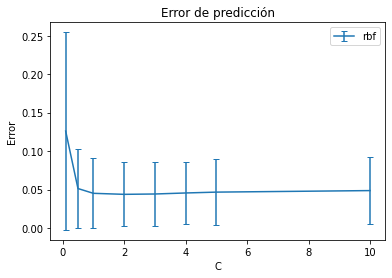

In [15]:
top10 = cv_results[cv_results['rank_test_score'] <= 10]
display(top10.loc[:, ['param_kernel', 'param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']])

plt.errorbar(cv_results["param_C"],
            1-cv_results['mean_test_score'],
            cv_results['std_test_score'],
             label = 'rbf',
            capsize=3)

plt.title("Error de predicción")
plt.xlabel("C")
plt.ylabel("Error")
plt.legend(loc='upper right')
plt.show()

Obtenemos unos resultados bastante similares al caso anterior, como era de esperar.
Habiendo confirmado esto, lo más justo es comparar ambos casos con los mismos hiperparámetros para el algoritmos, a pesar de que los datos no sean los mismos.
Por tanto, volvemos a elegir `C = 10` y `kernel = rbf` y entrenamos.

In [16]:
clf = SVC(kernel = 'rbf', C = 10, random_state = SEED_VALUE)

clf.fit(xTrain, yTrain)
result = clf.predict(xTest)
print("Exactitud del algoritmo ('Accuracy'): {}".format(accuracy_score(yTest, result)))

Exactitud del algoritmo ('Accuracy'): 0.8945736434108527


Obtenemos un `accuracy` de 0.89, frente al 0.72 que obtuvimos para diferenciar personalidades similares.
Por tanto, podemos confirmar que la hipótesis de que es más sencillo diferenciar personalidades diferentes que similares es correcta.
Probablemente venga determinada en este caso por el vocabulario específico y la posible diferencia de edad.
La forma de escribir no es la misma para personas de edades muy diferentes, además de que unas se dedican al automovilismo y tendrán una mayor cantdidad de palabras dedicadas al mismo, meintras que Bill Gates está más enfocado en la tecnología en general y actividades humanitarias.
Estas podrían ser las razones de que la puntuación obtenida a la hora de diferenciar las personalidades sea más alta, mientras que en las personalidades similares, al hablar de los mismos temas y siendo de la misma edad, pueden complicar notablemente la eficacia del algoritmo.

### Análisis de sentimientos mediante VADER

Se nos pide realizar un análisis de los sentimientos utilizando la herramienta `VADER`.
No se nos propone un objetivo particular más allá de la utilización de la herramienta, por lo que planteo la idea de utilizarla para medir estado emocional de un piloto a lo largo de su carrera, utilizando ventanas temporales de una semana.

Es importante destacar que esta experimentación habría sido más eficaz e interesante en caso de contar con cuentas que no perteneciesen a personajes públicos.
Esto es debido a que este tipo de perfiles suelen hablar de una forma muy similar y __neutra__ en diferentes situaciones, con el fin de mantener una imagen y reputación.
Podría resultar más interesante aplicarla a un usuario corriente que utiliza la red social sin un propósito de promoción o similar.


Vamos a comenzar cargando el analizador y los tweets del perfil a analizar.
En este caso utilizaremos a George Russell, el cual tiene tweets desde 2011.

In [17]:
analyser = SentimentIntensityAnalyzer()
collection = extract_XML('GeorgeRussell63.xml', include_date = True)

Vamos a definir una serie de funciones que nos permitirán  realizar el procesamiento temporal de los tweets.

In [18]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

def get_next_monday(date):
    return date + timedelta(days=-date.weekday(), weeks=1)

def sentiment_over_time(collection):
    next_monday = None
    prev_monday = None
    sentiment = []
    all_time = pd.DataFrame()
    for tweet in reversed(collection):
        if next_monday == None:
            next_monday = get_next_monday(tweet[1])
            prev_monday = tweet[1]
        if tweet[1] > next_monday:
            temp = {
                'date':prev_monday,
                'sentiment':mean(sentiment)}
            all_time = all_time.append(temp, ignore_index = True)
            # Limpiar array
            sentiment = []
            # Actualizar fechas
            prev_monday = next_monday
            next_monday = get_next_monday(tweet[1])

        # Incluir nuevo dato
        sentiment.append(sentiment_analyzer_scores(tweet[0])['compound'])
        
    return all_time

def feeling_over_time(df):
    plt.rcParams['figure.figsize'] = [20, 5]
    
    plt.plot(df["date"],
             df['sentiment'],
             label="Feeling over time")

    plt.title("Feeling over time")
    plt.xlabel("Week")
    plt.ylabel("Feeling")
    plt.legend(loc='upper right')

    plt.show()

A continuación, solo tenemos que llamar a las funciones y todo irá sobre ruedas.

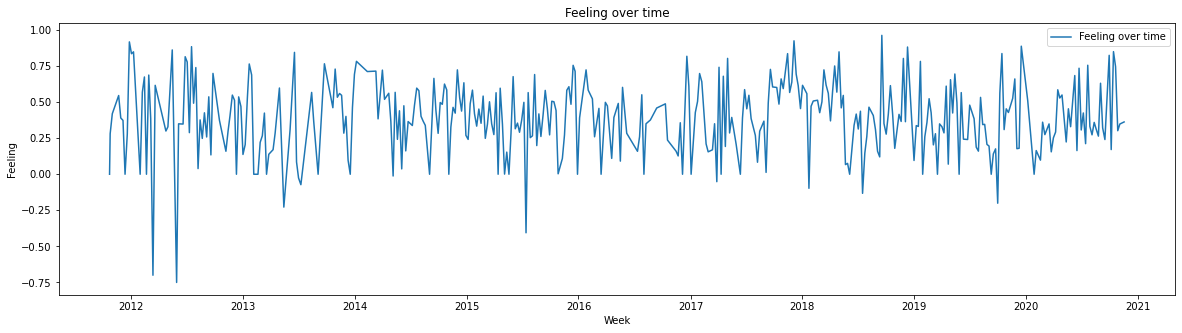

In [19]:
df = sentiment_over_time(collection)
feeling_over_time(df)

Como ya hemos comentado, estos perfiles de personajes públicos se suelen mantener bastante neutros o positivos, pero rara vez tienen mensajes negativos.
Observamos dos picos muy negativos en el 2012, y dada la edad del piloto en esa época (14 años), podemos adjudicarsela a algún día malo durante la adolescencia, cuando aun no era un personaje público conocido.
Para afinar esta experimentación un poco más, vamos a probar con otro perfil que no hayamos tenido en cuenta hasta ahora.

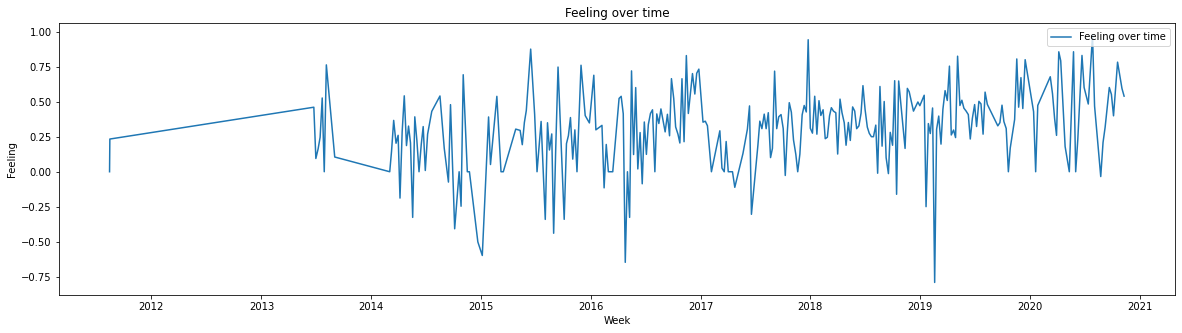

In [20]:
user = 'hellomayuko'
if not os.path.exists("./extracted_users/" + user + ".xml"):
    timeline(user)
collection = extract_XML('hellomayuko.xml', include_date = True)
df = sentiment_over_time(collection)
feeling_over_time(df)

Mayuko es una desarrolladora de software especializada en iOS, y actualmente posee un canal de YouTube en el que cuenta su vida como desarrolladora y da consejos a personas adentrandose en la industria de la informática y la programación.
No es extremadamente conocida y posee relativamente pocos seguidores en twitter.
Esto da pie a que muestre más sus sentimientos de manera pública y sea más activa en la red social.

Vemos un par de parones entre 2012 y 2014, donde parece que el usuario no utilizó la red social.
Pero encontramos muchas más semanas negativas que con Russell, lo cual podría ser un indicativo de que mi hipótesis sobre lo abiertos que son los personajes públicos en las redes sociales es cierta, aunque mi intención no es probar esta teoría.

Podemos encontrar muchas aplicaciones para el análisis de sentimientos, pero sería más eficaz respecto a un tema concreto.
Por ejemplo, recogiendo tweets con un hashtag concreto podríamos medir la opinión de la gente respecto a un tema concreto, y de hecho, ya se usa para esto. 

Con esto, podemos dar por finalizado el análisis de sentimientos